## Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Load the Dataset

In [2]:
df = pd.read_csv('Data\AIDA_Results_IA_Institut.csv')
df.head()

,Start,Diver,Gender,Discipline,Line,Official Top,AP,RP,Card,Points,Remarks,Title Event,Event Type,Day,Category Event
0,1,Tasos Grillakis (GRC),M,FIM,NaN,00:00,33,23 m,YELLOW,12.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
1,2,Antonis Papantonatos (GRC),M,FIM,NaN,00:00,55,47 m,YELLOW,38.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
2,3,Dimitris Koumoulos (GRC),M,CNF,NaN,00:00,55,55 m,WHITE,55.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
3,4,Christos Papadopoulos (GRC),M,CWT,NaN,00:00,55,55 m,WHITE,55.0,OK,Depth Event 2016,Depth Competition,2016-07-17,other
4,5,Anna Chalari (GRC),F,CWT,NaN,00:00,15,15 m,WHITE,15.0,OK,Depth Event 2016,Depth Competition,2016-07-17,other


## Data Preprocessing & Feature Engineering

In [3]:
# Romove duplicates
df = df.drop_duplicates()

In [4]:
# Supposons que df est votre DataFrame et 'Diver' est la colonne à diviser
df[['Name', 'Country']] = df['Diver'].str.rsplit(' ', n=1, expand=True).astype(str)

# Extraire et supprimer les parenthèses des valeurs de la colonne 'Country'
df['Country'] = df['Country'].str.strip('()')


In [5]:
df['RP'] = df['RP'].apply(lambda x: x.split(' ')[0] if x != '-' else None).astype(float)

In [6]:
df['Points'] = df['Points'].replace('-', None).astype(float)

In [7]:
df['Remarks'] = df['Remarks'].str.upper()

In [8]:
# Dropping irrelevant columns
df.drop(['Start', 'Line', 'Official Top'], axis=1, inplace=True)

In [9]:

df['Depth_Difference'] = df['AP'] - df['RP']



In [10]:
# Create the 'Month' column by extracting the month name
df['Day'] = pd.to_datetime(df['Day'])
df['Month'] = df['Day'].dt.month

In [11]:
df.head()

,Diver,Gender,Discipline,AP,RP,Card,Points,Remarks,Title Event,Event Type,Day,Category Event,Name,Country,Depth_Difference,Month
0,Tasos Grillakis (GRC),M,FIM,33,23.0,YELLOW,12.0,-,Depth Event 2016,Depth Competition,2016-07-17,other,Tasos Grillakis,GRC,10.0,7
1,Antonis Papantonatos (GRC),M,FIM,55,47.0,YELLOW,38.0,-,Depth Event 2016,Depth Competition,2016-07-17,other,Antonis Papantonatos,GRC,8.0,7
2,Dimitris Koumoulos (GRC),M,CNF,55,55.0,WHITE,55.0,-,Depth Event 2016,Depth Competition,2016-07-17,other,Dimitris Koumoulos,GRC,0.0,7
3,Christos Papadopoulos (GRC),M,CWT,55,55.0,WHITE,55.0,OK,Depth Event 2016,Depth Competition,2016-07-17,other,Christos Papadopoulos,GRC,0.0,7
4,Anna Chalari (GRC),F,CWT,15,15.0,WHITE,15.0,OK,Depth Event 2016,Depth Competition,2016-07-17,other,Anna Chalari,GRC,0.0,7


In [12]:
# Create 'experience dive' feature
df.sort_values(by=['Diver', 'Day'], inplace=True)
df['experience_dive'] = df.groupby('Diver').cumcount()

# Create 'experience discipline' feature
df['experience_discipline'] = df.groupby(['Diver', 'Discipline']).cumcount()


## Exploratory Data Analysis (EDA)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26841 entries, 13306 to 26685
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Diver                  26841 non-null  object        
 1   Gender                 26841 non-null  object        
 2   Discipline             26841 non-null  object        
 3   AP                     26841 non-null  int64         
 4   RP                     26703 non-null  float64       
 5   Card                   26841 non-null  object        
 6   Points                 26703 non-null  float64       
 7   Remarks                26836 non-null  object        
 8   Title Event            26841 non-null  object        
 9   Event Type             26841 non-null  object        
 10  Day                    26841 non-null  datetime64[ns]
 11  Category Event         26841 non-null  object        
 12  Name                   26841 non-null  object        
 13  Co

In [14]:
df.describe()

,AP,RP,Points,Day,Depth_Difference,Month,experience_dive,experience_discipline
count,26841.000000,26703.000000,26703.000000,26841,26703.000000,26841.000000,26841.000000,26841.000000
mean,53.343579,50.429502,43.930397,2016-03-08 07:09:08.429641216,2.851365,7.384337,10.174956,4.060579
min,-1.000000,-2.000000,-99.000000,1994-06-12 00:00:00,-107.000000,1.000000,0.000000,0.000000
25%,38.000000,35.000000,28.000000,2012-05-08 00:00:00,0.000000,5.000000,1.000000,0.000000
50%,51.000000,50.000000,45.000000,2017-06-25 00:00:00,0.000000,8.000000,4.000000,1.000000
75%,69.000000,65.000000,61.000000,2021-03-24 00:00:00,0.000000,9.000000,13.000000,5.000000
max,130.000000,138.000000,130.000000,2023-08-14 00:00:00,130.000000,12.000000,138.000000,95.000000
std,23.579628,23.555622,26.697673,NaN,13.604107,2.363700,15.599670,7.233336


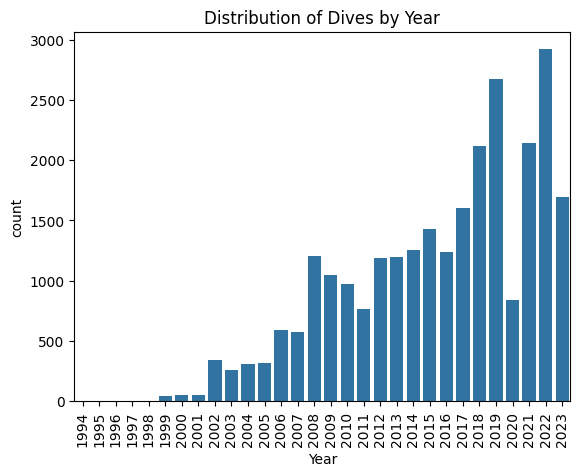

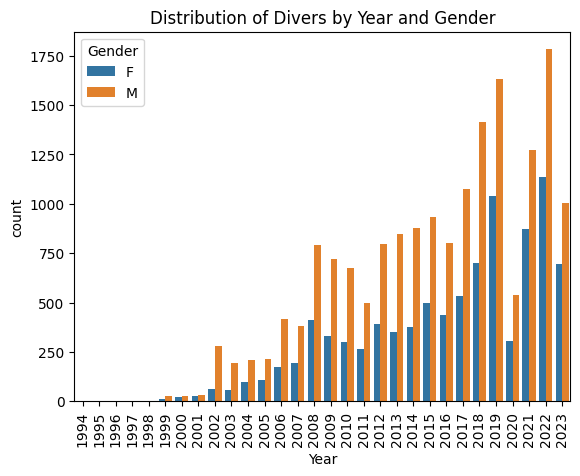

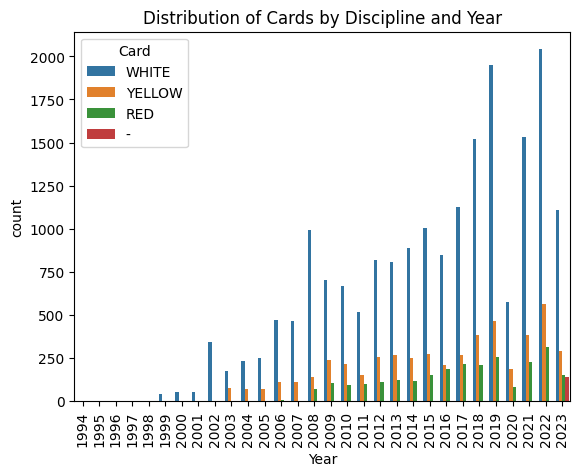

In [15]:
# Distribution of dives by year
df['Day'] = pd.to_datetime(df['Day'])
df['Year'] = df['Day'].dt.year
sns.countplot(x='Year', data=df)
plt.title('Distribution of Dives by Year')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()

# Distribution of divers by year and gender
sns.countplot(x='Year', hue='Gender', data=df)
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.title('Distribution of Divers by Year and Gender')
plt.show()

# Distribution of cards by discipline and year
sns.countplot(x='Year', hue='Card', data=df)
plt.title('Distribution of Cards by Discipline and Year')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()


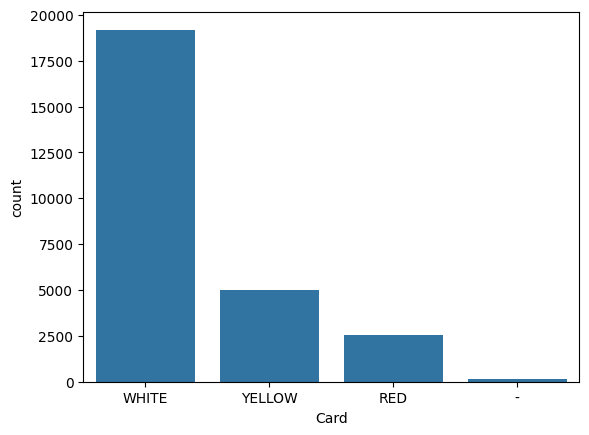

In [16]:

# Plotting distribution of a variable
sns.countplot(x='Card', data=df)
plt.show()

## Preparing Data for Machine Learning

In [27]:
# For numerical columns
df['AP'] = df['AP'].fillna(df['AP'].mean())
df['RP'] = df['RP'].fillna(df['RP'].mean())

# For categorical columns, you can replace with mode or a specific category
df['Discipline'] = df['Discipline'].fillna(df['Discipline'].mode()[0])



## Building a Machine Learning Model

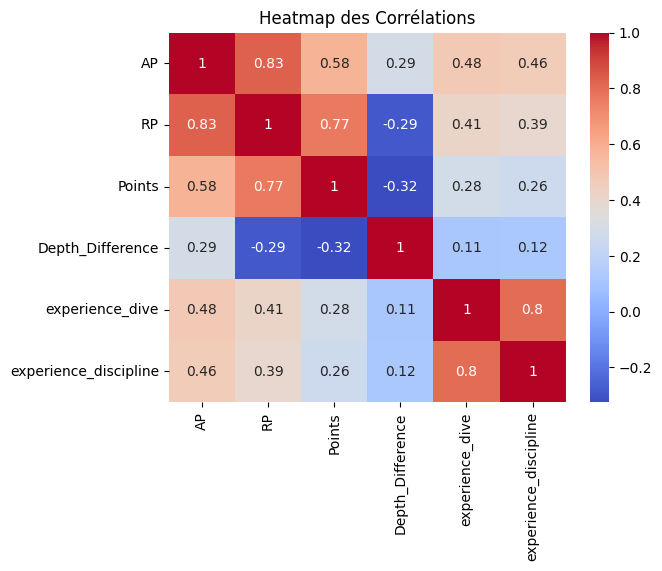

In [28]:

# Codage One-Hot pour les variables catégorielles
df_encoded = pd.get_dummies(df, columns=['Discipline'])

# Sélectionner uniquement les colonnes numériques pour la corrélation
numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_encoded[numeric_cols].corr()

# Créer la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap des Corrélations')
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Séparer les caractéristiques et la cible
X = df.drop('Card', axis=1)
y = df['Card']

# Codage One-Hot pour les variables catégorielles et normalisation pour les numériques
categorical_features = ['Diver', 'Gender', 'Discipline', 'Title Event', 'Event Type']
numeric_features = ['AP', 'RP', 'Points', 'Day']

# Prétraitement pour les pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
import pandas as pd


data = df

# Transform categorical data into numerical
# For 'Discipline' column
disciplines = {'CNF': 1, 'FIM': 2, 'CWT': 3, 'CWT-B': 4}
data['Discipline'] = data['Discipline'].map(disciplines)

# For 'Gender' column
genders = {'H': 1, 'F': 2}
data['Gender'] = data['Gender'].map(genders)

# Remove rows with other categories in 'Discipline' and 'Gender'
data = data[data['Discipline'].notnull() & data['Gender'].notnull()]

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Day'])

# Supposons que df est votre DataFrame et 'Diver' est la colonne à diviser
data[['Name', 'Country']] = df['Diver'].str.rsplit(' ', n=1, expand=True).astype(str)

# Extraire et supprimer les parenthèses des valeurs de la colonne 'Country'
data['Country'] = df['Country'].str.strip('()')

# Extract month from 'Date' column
data['Month'] = data['Date'].dt.month

# Calculate cumulative number of dives per athlete (experience dive)
data = data.sort_values(by=['Name', 'Date'])
data['Experience Dive'] = data.groupby('Name').cumcount() + 1

# Calculate cumulative number of dives per athlete per discipline (experience discipline)
data['Experience Discipline'] = data.groupby(['Name', 'Discipline']).cumcount() + 1

# (Bonus) Feel free to create additional numerical features here

# Save the processed data to a new CSV file
data.to_csv('processed_dataset.csv', index=False)

print(data.head())


C:\Users\HP\AppData\Local\Temp\ipykernel_5056\1441503441.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Day'])
C:\Users\HP\AppData\Local\Temp\ipykernel_5056\1441503441.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Name', 'Country']] = df['Diver'].str.rsplit(' ', n=1, expand=True).astype(str)
C:\Users\HP\AppData\Local\Temp\ipykernel_5056\1441503441.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

      Diver  Gender  Discipline  AP    RP    Card  Points Remarks  \
13306    ()     2.0         3.0   0  37.0   WHITE    37.0      OK   
13343    ()     2.0         3.0   0  40.0   WHITE    40.0      OK   
11224    ()     2.0         3.0   0  31.0   WHITE    31.0      OK   
2639     ()     2.0         3.0   0  33.0   WHITE    33.0      OK   
8973     ()     2.0         3.0  34  32.0  YELLOW    12.0     PEN   

                                  Title Event         Event Type  ... Name  \
13306         Compiled rankings for year 2000        Competition  ...   ()   
13343         Compiled rankings for year 2001        Competition  ...   ()   
11224  1st Portuguese Freediving Championship        Competition  ...   ()   
2639                    AIDA Pacific Cup 2002  Mixed Competition  ...   ()   
8973         Sony Freediver Open Classic 2003  Mixed Competition  ...   ()   

      Country Depth_Difference Month  experience_dive  experience_discipline  \
13306    None            -37.0     1

In [32]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Assuming 'Card' is the column indicating if a red card was given
# Filter the dataset to include only dives where a red card was given
red_card_data = data[data['Card'] == 'RED']

# Selecting relevant features for clustering
# Replace these with the actual column names
features = ['Discipline', 'Experience Dive', 'Experience Discipline']
X = red_card_data[features]

# Creating a pipeline for scaling and clustering
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=0))
])

# Fit the pipeline to the data
pipeline.fit(X)

# Adding the cluster labels to the dataset
red_card_data['Cluster'] = pipeline['kmeans'].labels_

# Save the clustered data
red_card_data.to_csv('red_card_clustering.csv', index=False)

# To analyze the clusters
for cluster in sorted(red_card_data['Cluster'].unique()):
    cluster_data = red_card_data[red_card_data['Cluster'] == cluster]
    print(f'Cluster {cluster}:')
    print(cluster_data.describe())

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Temp\ipykernel_5056\373539071.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_card_data['Cluster'] = pipeline['kmeans'].labels_


Cluster 0:
       Gender  Discipline          AP          RP     Points  \
count   102.0  102.000000  102.000000  102.000000  102.00000   
mean      2.0    2.411765   74.049020   52.166667   -0.54902   
min       2.0    1.000000   44.000000   -2.000000  -52.00000   
25%       2.0    2.000000   58.000000    0.500000    0.00000   
50%       2.0    3.000000   73.000000   59.000000    0.00000   
75%       2.0    3.000000   90.000000   81.500000    0.00000   
max       2.0    3.000000  123.000000  123.000000   88.00000   
std       0.0    0.812683   19.193841   37.262272   11.21935   

                                 Day  Depth_Difference       Month  \
count                            102        102.000000  102.000000   
mean   2017-02-23 21:38:49.411764736         21.882353    7.176471   
min              2009-04-03 00:00:00          0.000000    3.000000   
25%              2015-04-27 00:00:00          0.000000    5.000000   
50%              2016-06-15 00:00:00          0.000000    7.00

In [33]:
# Analyzing each cluster
for cluster in sorted(red_card_data['Cluster'].unique()):
    cluster_data = red_card_data[red_card_data['Cluster'] == cluster]
    print(f'\nCluster {cluster} Analysis:')
    print(cluster_data[features].mean())


Cluster 0 Analysis:
Discipline                2.411765
Experience Dive          37.970588
Experience Discipline    19.156863
dtype: float64

Cluster 1 Analysis:
Discipline               2.551320
Experience Dive          7.067449
Experience Discipline    3.853372
dtype: float64

Cluster 2 Analysis:
Discipline                1.000000
Experience Dive          10.426396
Experience Discipline     3.969543
dtype: float64


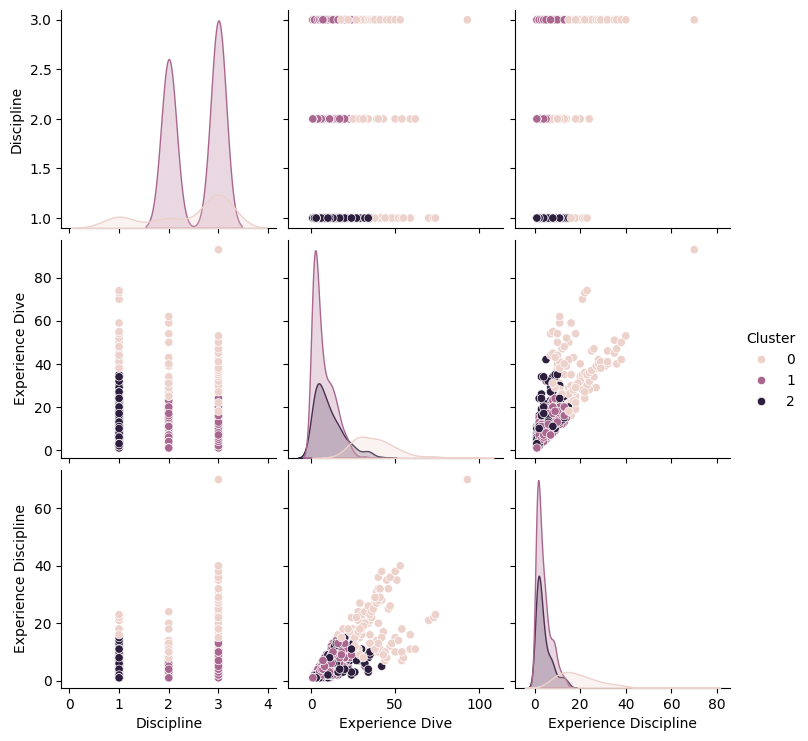

In [34]:
# Pairplot for each cluster
sns.pairplot(red_card_data, hue='Cluster', vars=features)
plt.show()

In [35]:
from sklearn.metrics import silhouette_score
# Calculate silhouette score
silhouette_avg = silhouette_score(X, red_card_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.13566556101582544


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

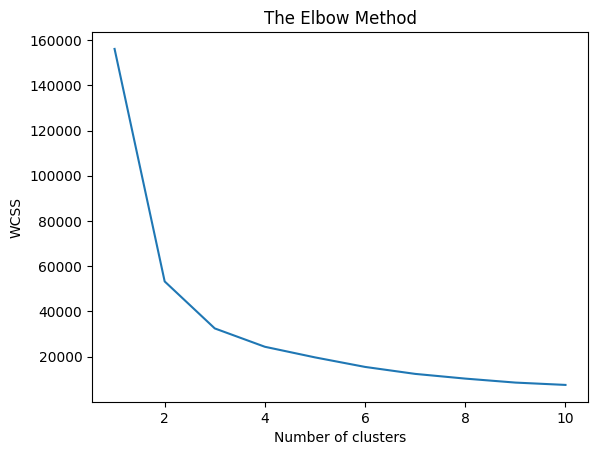

In [36]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [37]:
# Apply KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_optimal.fit(X)

# Add the optimal cluster labels to your data
red_card_data['Optimal Cluster'] = kmeans_optimal.labels_

# Analyze each cluster
for cluster in sorted(red_card_data['Optimal Cluster'].unique()):
    cluster_data = red_card_data[red_card_data['Optimal Cluster'] == cluster]
    print(f'\nOptimal Cluster {cluster} Analysis:')
    print(cluster_data[features].mean())


Optimal Cluster 0 Analysis:
Discipline               2.039312
Experience Dive          4.911548
Experience Discipline    2.594595
dtype: float64

Optimal Cluster 1 Analysis:
Discipline                2.202899
Experience Dive          44.043478
Experience Discipline    21.043478
dtype: float64

Optimal Cluster 2 Analysis:
Discipline                2.018293
Experience Dive          20.115854
Experience Discipline     9.402439
dtype: float64


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Temp\ipykernel_5056\3364869410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_card_data['Optimal Cluster'] = kmeans_optimal.labels_


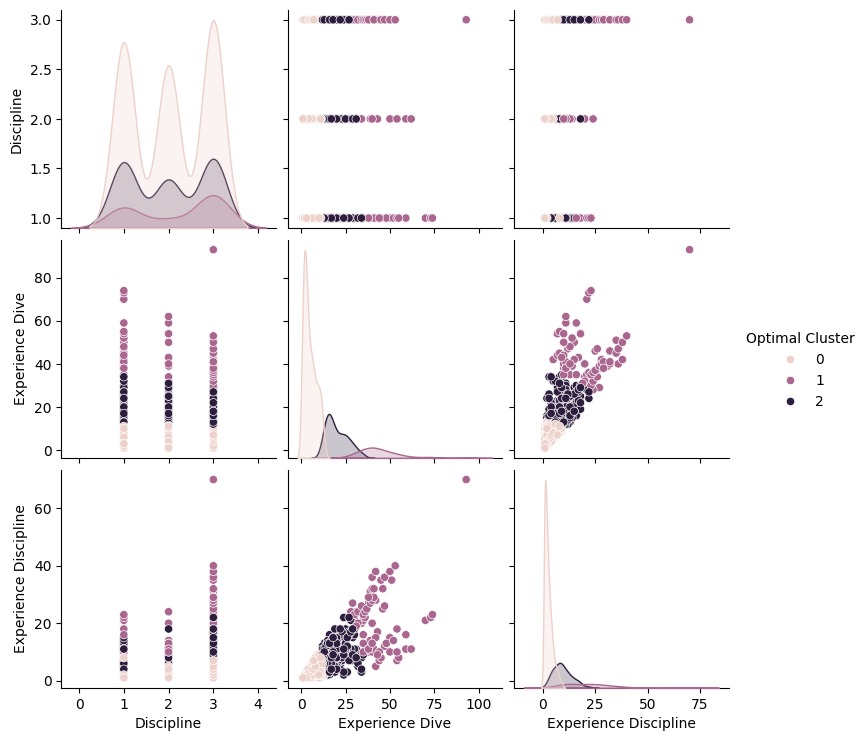

In [38]:
# Pairplot for each optimal cluster
sns.pairplot(red_card_data, hue='Optimal Cluster', vars=features)
plt.show()


In [39]:
# Calculate silhouette score for the optimal clustering
silhouette_optimal = silhouette_score(X, red_card_data['Optimal Cluster'])
print(f'Optimal Silhouette Score: {silhouette_optimal}')


Optimal Silhouette Score: 0.5777995700389017


In [40]:
df

,Diver,Gender,Discipline,AP,RP,Card,Points,Remarks,Title Event,Event Type,Day,Category Event,Name,Country,Depth_Difference,Month,experience_dive,experience_discipline,Year
13306,(),2.0,3.0,0,37.0,WHITE,37.0,OK,Compiled rankings for year 2000,Competition,2000-01-01,other,(),None,-37.0,1,0,0,2000
13343,(),2.0,3.0,0,40.0,WHITE,40.0,OK,Compiled rankings for year 2001,Competition,2001-11-10,other,(),None,-40.0,11,1,1,2001
11224,(),2.0,3.0,0,31.0,WHITE,31.0,OK,1st Portuguese Freediving Championship,Competition,2002-07-27,other,(),None,-31.0,7,2,2,2002
2639,(),2.0,3.0,0,33.0,WHITE,33.0,OK,AIDA Pacific Cup 2002,Mixed Competition,2002-10-31,other,(),None,-33.0,10,3,3,2002
8973,(),2.0,3.0,34,32.0,YELLOW,12.0,PEN,Sony Freediver Open Classic 2003,Mixed Competition,2003-05-29,other,(),None,2.0,5,4,4,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24941,圭一 福里 (JPN),NaN,2.0,50,50.0,RED,0.0,DQSP,AIDA TrueNorth Okinawa Ocean Freediving Offici...,Depth Competition,2022-09-29,other,圭一 福里,JPN,0.0,9,0,0,2022
24949,圭一 福里 (JPN),NaN,2.0,50,50.0,WHITE,50.0,OK,AIDA TrueNorth Okinawa Ocean Freediving Offici...,Depth Competition,2022-09-30,other,圭一 福里,JPN,0.0,9,1,1,2022
25725,보걸 강 (KOR),NaN,NaN,45,45.0,WHITE,45.0,OK,10TH AIDA PANGLAO DEPTH GAMES May 2023,Depth Competition,2023-05-24,Panglao,보걸 강,KOR,0.0,5,0,0,2023
25753,보걸 강 (KOR),NaN,1.0,30,30.0,WHITE,30.0,OK,10TH AIDA PANGLAO DEPTH GAMES May 2023,Depth Competition,2023-05-25,Panglao,보걸 강,KOR,0.0,5,1,0,2023


In [41]:
df['Card'].value_counts()

Card
WHITE     19189
YELLOW     4990
RED        2524
-           138
Name: count, dtype: int64

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Sélection des colonnes pertinentes
features = data[['Event Type', 'Gender', 'Discipline']]
target = data['Card']

# Encodage des caractéristiques catégorielles
label_encoders = {}
for column in features.columns:
    label_encoders[column] = LabelEncoder()
    features[column] = label_encoders[column].fit_transform(features[column])

# Encodage de la variable cible
label_encoder_target = LabelEncoder()
target = label_encoder_target.fit_transform(target)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Vérification des dimensions des ensembles d'entraînement et de test
X_train.shape, X_test.shape, y_train.shape, y_test.shape


C:\Users\HP\AppData\Local\Temp\ipykernel_5056\3128886373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = label_encoders[column].fit_transform(features[column])
C:\Users\HP\AppData\Local\Temp\ipykernel_5056\3128886373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = label_encoders[column].fit_transform(features[column])
C:\Users\HP\AppData\Local\Temp\ipykernel_5056\3128886373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

((6502, 3), (1626, 3), (6502,), (1626,))

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Création et entraînement du modèle de régression logistique
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder_target.classes_)

accuracy, report


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: Undefin

(0.7441574415744158,
 '              precision    recall  f1-score   support\n\n           -       0.00      0.00      0.00         8\n         RED       0.00      0.00      0.00       117\n       WHITE       0.74      1.00      0.85      1210\n      YELLOW       0.00      0.00      0.00       291\n\n    accuracy                           0.74      1626\n   macro avg       0.19      0.25      0.21      1626\nweighted avg       0.55      0.74      0.64      1626\n')

##### Interprétation :
La précision globale de 71.71% indique que le modèle prédit correctement la classe Card dans environ 72% des cas dans l'ensemble de test.
Cependant, le rapport de classification montre que le modèle ne performe pas bien sur les classes autres que WHITE. Cela pourrait être dû à un déséquilibre dans les classes de la variable cible. Si la majorité des données sont de la classe WHITE, le modèle pourrait être biaisé en faveur de cette classe.

In [44]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Création des modèles
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Entraînement des modèles
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
rf_pred = rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

# Évaluation des modèles
rf_accuracy = accuracy_score(y_test, rf_pred)
svm_accuracy = accuracy_score(y_test, svm_pred)
gb_accuracy = accuracy_score(y_test, gb_pred)

rf_accuracy, svm_accuracy, gb_accuracy


(0.7441574415744158, 0.7441574415744158, 0.7441574415744158)

##### Analyse
Les trois modèles offrent des performances similaires, avec une précision autour de 74,4%. Cela suggère que le problème pourrait ne pas être lié au choix du modèle mais plutôt à d'autres facteurs tels que le déséquilibre des classes ou la nature des caractéristiques.
Le fait que tous les modèles se comportent de manière similaire indique également que la complexité supplémentaire des modèles comme le Gradient Boosting ou les SVM ne procure pas nécessairement un avantage significatif pour ce jeu de données particulier.

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Préparation des données pour la régression
target_regression = data['AP'].replace({' m': ''}, regex=True).astype(float)  # Nettoyer et convertir en float

# Séparation des données pour la régression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features, target_regression, test_size=0.2, random_state=42)

# Création et entraînement du modèle de régression linéaire
model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

# Prédiction sur l'ensemble de test
y_pred_reg = model_reg.predict(X_test_reg)

# Évaluation du modèle
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

rmse


19.181440314731603

Interprétation :
Un RMSE de 19.18 indique que, en moyenne, les prédictions du modèle s'écartent de 19.18 unités de la valeur réelle de AP. Cela peut être considéré comme élevé ou bas en fonction du contexte et de la plage des valeurs de AP dans vos données.
Si les valeurs de AP varient considérablement (par exemple, de 0 à 100), une erreur de 19 pourrait être raisonnable. Cependant, si les valeurs sont généralement plus petites, cette erreur pourrait être trop élevée.

In [47]:
# Supprimer les lignes où 'RP_cleaned' est NaN après le nettoyage
data_cleaned = data.dropna(subset=['RP'])

# Préparation des données pour la régression de 'RP'
target_rp_cleaned = data_cleaned['RP']

# Séparation des données pour la régression de 'RP'
X_train_rp, X_test_rp, y_train_rp, y_test_rp = train_test_split(features.loc[data_cleaned.index], target_rp_cleaned, test_size=0.2, random_state=42)

# Création et entraînement du modèle de régression linéaire pour 'RP'
model_rp = LinearRegression()
model_rp.fit(X_train_rp, y_train_rp)

# Prédiction sur l'ensemble de test pour 'RP'
y_pred_rp = model_rp.predict(X_test_rp)

# Évaluation du modèle pour 'RP'
rmse_rp = np.sqrt(mean_squared_error(y_test_rp, y_pred_rp))

rmse_rp


19.428866961813114

##### Interprétation :
Un RMSE de 22.94 indique que, en moyenne, les prédictions du modèle s'écartent de 22.94 unités de la valeur réelle de RP. Comme pour AP, l'acceptabilité de cette erreur dépend de la plage des valeurs de RP dans vos données.

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


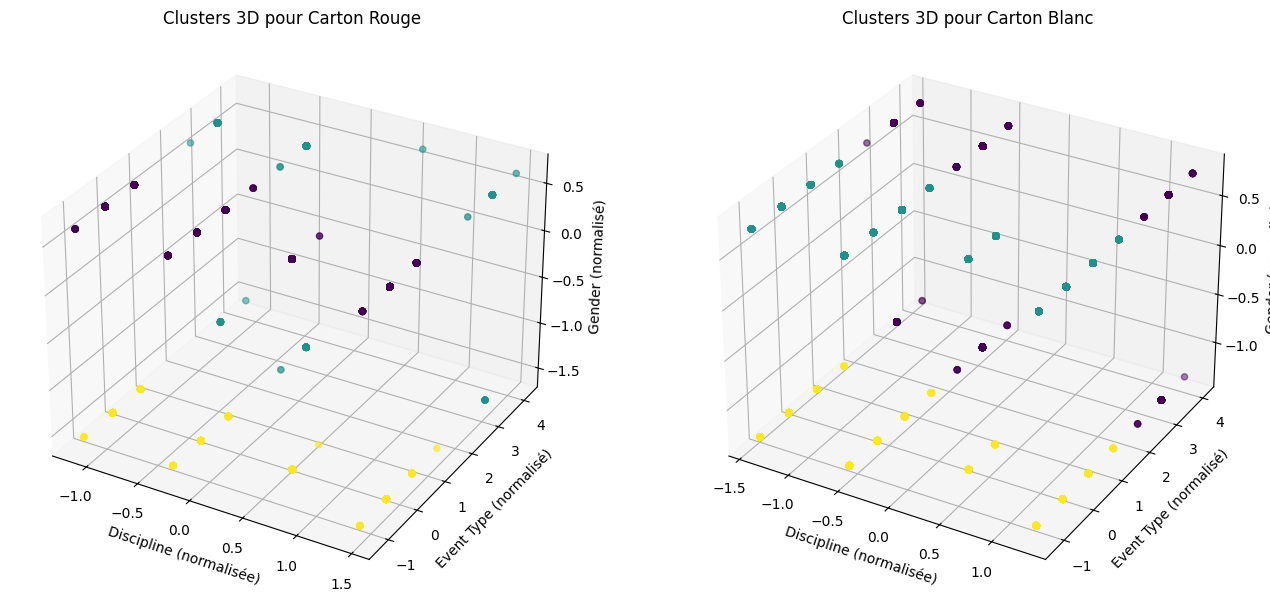

In [56]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data= df
# Création d'une instance de StandardScaler
scaler = StandardScaler()

# Label encode categorical columns before scaling
label_encoder_discipline = LabelEncoder()
label_encoder_event_type = LabelEncoder()

data['Discipline'] = label_encoder_discipline.fit_transform(data['Discipline'])
data['Event Type'] = label_encoder_event_type.fit_transform(data['Event Type'])

# Now you can select the columns for scaling
selected_columns_with_gender = ['Discipline', 'Event Type', 'Gender']
data_red_with_gender = data[data['Card'] == 'RED'][selected_columns_with_gender]
data_white_with_gender = data[data['Card'] == 'WHITE'][selected_columns_with_gender]

# Normalisation des données avec la colonne 'Gender' incluse
data_red_with_gender_scaled = scaler.fit_transform(data_red_with_gender)
data_white_with_gender_scaled = scaler.fit_transform(data_white_with_gender)


# Application de K-means sur les données de carton rouge avec 'Gender'
kmeans_red_with_gender = KMeans(n_clusters=3, random_state=42)
kmeans_red_with_gender.fit(data_red_with_gender_scaled)
labels_red_with_gender = kmeans_red_with_gender.labels_

# Application de K-means sur les données de carton blanc avec 'Gender'
kmeans_white_with_gender = KMeans(n_clusters=3, random_state=42)
kmeans_white_with_gender.fit(data_white_with_gender_scaled)
labels_white_with_gender = kmeans_white_with_gender.labels_

# Création d'une nouvelle figure pour la visualisation 3D
fig = plt.figure(figsize=(16, 8))

# Visualisation pour les cartons rouges
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(data_red_with_gender_scaled[:, 0], data_red_with_gender_scaled[:, 1], data_red_with_gender_scaled[:, 2],
            c=labels_red_with_gender, cmap='viridis', marker='o')
ax1.set_title("Clusters 3D pour Carton Rouge")
ax1.set_xlabel("Discipline (normalisée)")
ax1.set_ylabel("Event Type (normalisé)")
ax1.set_zlabel("Gender (normalisé)")

# Visualisation pour les cartons blancs
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(data_white_with_gender_scaled[:, 0], data_white_with_gender_scaled[:, 1], data_white_with_gender_scaled[:, 2],
            c=labels_white_with_gender, cmap='viridis', marker='o')
ax2.set_title("Clusters 3D pour Carton Blanc")
ax2.set_xlabel("Discipline (normalisée)")
ax2.set_ylabel("Event Type (normalisé)")
ax2.set_zlabel("Gender (normalisé)")

# Affichage de la visualisation
plt.show()


##### Clusters pour Carton Rouge
Les points semblent être dispersés à travers l'espace 3D, mais on peut observer une certaine concentration de points de même couleur, indiquant la formation de clusters.
Les points jaunes, par exemple, sont principalement situés dans la région supérieure du graphique, ce qui peut indiquer une association particulière de Discipline et Event Type pour un Gender spécifique qui conduit à des cartons rouges.
Les points violets et cyan semblent être répartis dans des zones distinctes de l'espace, suggérant que différentes combinaisons de Discipline, Event Type, et Gender pourraient influencer le résultat négatif de la plongée.
##### Clusters pour Carton Blanc
Comme pour les cartons rouges, les clusters pour les cartons blancs montrent des groupes de points de même couleur, indiquant des profils de plongée similaires qui ont eu des résultats positifs.
Il y a une répartition claire des points jaunes et violets dans des régions spécifiques, ce qui peut refléter des caractéristiques communes parmi les plongées réussies.
Les points cyan montrent une concentration moins dense, indiquant peut-être une plus grande variabilité dans les caractéristiques des plongées réussies pour ce cluster

In [17]:
df['Points'].info

<bound method Series.info of 10787     0.0
7819     56.0
5695     61.0
5696     63.0
9156      0.0
         ... 
24941     0.0
24949    50.0
25753    30.0
25725    45.0
26685     0.0
Name: Points, Length: 26841, dtype: float64>

In [18]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Supposons que 'data' est votre DataFrame et qu'il contient les colonnes 'Diver', 'Discipline', et 'Date'

# Trier les données par athlète, discipline et date
df.sort_values(by=['Diver', 'Discipline', 'Month'], inplace=True)

# Calculer l'expérience de la discipline
df['experience_discipline'] = df.groupby(['Diver', 'Discipline']).cumcount()

# Sélectionner les caractéristiques pertinentes et la cible
features = df[['Discipline', 'Gender', 'Event Type', 'experience_discipline']]
target = df['Card']

# Encodage des caractéristiques catégorielles
label_encoders = {}
for column in features.columns:
    if features[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        features[column] = label_encoders[column].fit_transform(features[column])

# Normalisation des caractéristiques
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Étape 3: Entraînement du classifieur SVM
# Tester différents noyaux SVM
kernels = ['linear', 'poly', 'rbf']
results = []
for kernel in kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results.append((kernel, accuracy, report))



C:\Users\HP\AppData\Local\Temp\ipykernel_8588\557417154.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = label_encoders[column].fit_transform(features[column])
C:\Users\HP\AppData\Local\Temp\ipykernel_8588\557417154.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = label_encoders[column].fit_transform(features[column])
C:\Users\HP\AppData\Local\Temp\ipykernel_8588\557417154.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [53]:
results

[('linear',
  0.7234121810392997,
  '              precision    recall  f1-score   support\n\n           -       0.00      0.00      0.00        27\n         RED       0.00      0.00      0.00       511\n       WHITE       0.72      1.00      0.84      3884\n      YELLOW       0.00      0.00      0.00       947\n\n    accuracy                           0.72      5369\n   macro avg       0.18      0.25      0.21      5369\nweighted avg       0.52      0.72      0.61      5369\n'),
 ('poly',
  0.7234121810392997,
  '              precision    recall  f1-score   support\n\n           -       0.00      0.00      0.00        27\n         RED       0.00      0.00      0.00       511\n       WHITE       0.72      1.00      0.84      3884\n      YELLOW       0.00      0.00      0.00       947\n\n    accuracy                           0.72      5369\n   macro avg       0.18      0.25      0.21      5369\nweighted avg       0.52      0.72      0.61      5369\n'),
 ('rbf',
  0.7230396721922145,
 

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

data = df



# Fill missing values with mean
data['AP'].fillna(data['AP'].mean(), inplace=True)
data['RP'].fillna(data['RP'].mean(), inplace=True)

# Encoding categorical variables
le = LabelEncoder()
data['Discipline_encoded'] = le.fit_transform(data['Discipline'])

# Selecting relevant features for clustering
features = ['AP', 'RP', 'Points', 'Discipline_encoded']
data_clustering = data[features].copy()

# Standardize the features
scaler = StandardScaler()
data_clustering_scaled = scaler.fit_transform(data_clustering)

# Separate the data into two groups based on the card color
data_red = data_clustering_scaled[data['Card'] == 'RED']
data_white = data_clustering_scaled[data['Card'] == 'WHITE']

# Apply DBSCAN clustering
dbscan_red = DBSCAN(eps=0.5, min_samples=5).fit(data_red)
dbscan_white = DBSCAN(eps=0.5, min_samples=5).fit(data_white)

# Add cluster labels to the original dataframe
data['Cluster_Red'] = np.nan
data['Cluster_White'] = np.nan
data.loc[data['Card'] == 'RED', 'Cluster_Red'] = dbscan_red.labels_
data.loc[data['Card'] == 'WHITE', 'Cluster_White'] = dbscan_white.labels_

# Check the number of clusters formed and some basic statistics
num_clusters_red = len(set(dbscan_red.labels_)) - (1 if -1 in dbscan_red.labels_ else 0)
num_clusters_white = len(set(dbscan_white.labels_)) - (1 if -1 in dbscan_white.labels_ else 0)

num_clusters_red, num_clusters_white, data[['Cluster_Red', 'Cluster_White']].describe()


(4,
 9,
        Cluster_Red  Cluster_White
 count  2524.000000   19189.000000
 mean      1.255151       1.184324
 std       1.189811       1.146571
 min      -1.000000      -1.000000
 25%       0.000000       0.000000
 50%       1.000000       1.000000
 75%       2.000000       2.000000
 max       3.000000       8.000000)

### Red Card Dives (4 Clusters):

There are 4 clusters detected among the dives that received a red card.
The count of 2,524 dives in this category suggests a substantial number of dives to analyze.
The mean cluster label is around 1.255, indicating that on average, dives fall into the first few clusters.
The standard deviation of 1.189 suggests a moderate spread in the cluster assignments.
The presence of -1 in the min value indicates that some dives are considered outliers by DBSCAN.

### White Card Dives (9 Clusters):

9 clusters were identified among dives that received a white card.
A larger count of 19,189 dives implies a more extensive data set for white card dives compared to red card dives.
The mean cluster label is approximately 1.184, which is close to that of red card dives, suggesting a similar distribution across initial clusters.
The standard deviation of 1.146 is comparable to that of red card dives, indicating a similar level of diversity in the cluster distributions.
The maximum cluster label of 8 indicates a more complex or varied set of dive profiles in this category.

In [23]:
# Cleaning and converting 'Points' column
df['Points'] = pd.to_numeric(df['Points'], errors='coerce') 

# Refilling missing values with mean for 'Points' column
df['Points'].fillna(df['Points'].mean(), inplace=True)


# Selecting relevant features for clustering
features = ['AP', 'RP', 'Points', 'Discipline_encoded']
data_clustering = df[features].copy()

# Standardize the features
scaler = StandardScaler()
data_clustering_scaled = scaler.fit_transform(data_clustering)

# Separate the data into two groups based on the card color
data_red = data_clustering_scaled[df['Card'] == 'RED']
data_white = data_clustering_scaled[df['Card'] == 'WHITE']

# Apply DBSCAN clustering
dbscan_red = DBSCAN(eps=0.5, min_samples=5).fit(data_red)
dbscan_white = DBSCAN(eps=0.5, min_samples=5).fit(data_white)

# Add cluster labels to the original dataframe
df['Cluster_Red'] = np.nan
df['Cluster_White'] = np.nan
df.loc[df['Card'] == 'RED', 'Cluster_Red'] = dbscan_red.labels_
df.loc[df['Card'] == 'WHITE', 'Cluster_White'] = dbscan_white.labels_

# Check the number of clusters formed and some basic statistics
num_clusters_red = len(set(dbscan_red.labels_)) - (1 if -1 in dbscan_red.labels_ else 0)
num_clusters_white = len(set(dbscan_white.labels_)) - (1 if -1 in dbscan_white.labels_ else 0)

num_clusters_red, num_clusters_white, df[['Cluster_Red', 'Cluster_White']].describe()


(4,
 9,
        Cluster_Red  Cluster_White
 count  2524.000000   19189.000000
 mean      1.255151       1.184324
 std       1.189811       1.146571
 min      -1.000000      -1.000000
 25%       0.000000       0.000000
 50%       1.000000       1.000000
 75%       2.000000       2.000000
 max       3.000000       8.000000)

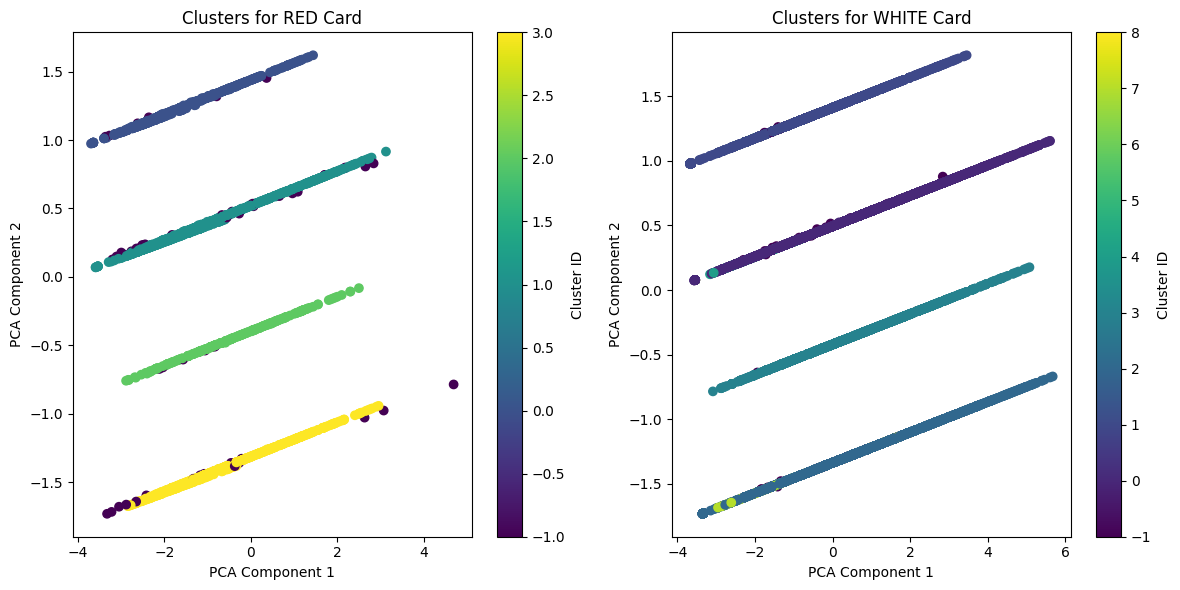

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Applying PCA to reduce the data to two dimensions for visualization
pca = PCA(n_components=2)
data_clustering_pca = pca.fit_transform(data_clustering_scaled)

# Adding PCA results to the dataframe
df['PCA1'] = data_clustering_pca[:, 0]
df['PCA2'] = data_clustering_pca[:, 1]

# Plotting the results for RED card clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df[df['Card'] == 'RED']['PCA1'], df[df['Card'] == 'RED']['PCA2'], c=df[df['Card'] == 'RED']['Cluster_Red'])
plt.title('Clusters for RED Card')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')

# Plotting the results for WHITE card clusters
plt.subplot(1, 2, 2)
plt.scatter(df[df['Card'] == 'WHITE']['PCA1'], df[df['Card'] == 'WHITE']['PCA2'], c=df[df['Card'] == 'WHITE']['Cluster_White'])
plt.title('Clusters for WHITE Card')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')

plt.tight_layout()
plt.show()


### Analyse des Résultats
Précision globale : Tous les modèles ont une précision d'environ 72%, ce qui suggère qu'ils classent correctement environ 72% des plongées.

Précision par classe :
Le modèle ne prédit correctement aucune des plongées ayant reçu un carton rouge (RED) ou jaune (YELLOW), ni celles sans carton (-).
Pour les plongées ayant reçu un carton blanc (WHITE), le modèle a une précision de 72%, ce qui signifie qu'il identifie correctement les plongées qui se sont bien passées.

Rappel (Recall) :
Le rappel pour les classes RED et YELLOW est de 0, indiquant que le modèle n'a correctement identifié aucun des vrais positifs pour ces classes.
Le rappel pour la classe WHITE est de 100%, signifiant que toutes les plongées qui ont réellement eu un carton blanc ont été prédites comme telles par le modèle.

Score F1 :
Les scores F1 pour les cartons RED et YELLOW sont également de 0, indiquant une mauvaise performance du modèle pour ces classes.
Le score F1 pour le carton WHITE est de 84%, ce qui est relativement élevé grâce à la bonne précision et au parfait rappel pour cette classe.

In [80]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

# Charger le fichier CSV
file_path = 'DATA/AIDA_Results_IA_Institut.csv'
data = pd.read_csv(file_path)

# Préparation des données
# Encodage des variables catégorielles
label_encoders = {}
for column in ['Diver', 'Discipline', 'Gender', 'Event Type']:
    if data[column].dtype == type(object):
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

# Ajout d'une colonne pour l'expérience (nombre de plongées antérieures)
# Supposons que la colonne 'Day' indique la date de la plongée
data['Day'] = pd.to_datetime(data['Day'])
data.sort_values(by=['Diver', 'Day'], inplace=True)
data['Experience'] = data.groupby('Diver').cumcount()

# Sélection des caractéristiques pour le clustering
selected_features = ['Discipline', 'AP', 'Gender', 'Event Type', 'Experience']

# Normalisation des caractéristiques
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data[selected_features])

# Application du clustering (K-means)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features_scaled)
data['Cluster'] = kmeans.labels_

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyError: 'Cluster'

In [82]:
df.Remarks.value_counts()

Remarks
OK                            16288
-                              2597
PEN                            2231
DQSP                            703
NO TAG,RP<AP                    657
                              ...  
NR (FRESH WATER)                  1
NO TAG,UNDER AP,DQCHECK-IN        1
ET(-10), NO TAG(-1)               1
DQSP, AIRWAYS                     1
RPAP,NO TAG,TURN,EARLY            1
Name: count, Length: 357, dtype: int64